In [62]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from timeit import default_timer as timer
import cv2
import os
from os import listdir
import matplotlib.pyplot as plt

from scripts.helper import *
from scripts.prepare_lib import *
from scripts.classify_lib import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [111]:
### file:

# pn = 'images/train/10/20171118_133018.jpg' ### läuft gut mit gray/thres
# pn = 'images/test/10/DSC_0043.JPG'   ### läuft mit 8px,adap
# pn = 'images/train/10/DSC_0035.JPG'  # läuft NICHT
# pn = 'images/train/10/DSC_0071.JPG'  # läuft NICHT
# pn = 'images/train/10/20171118_130352.jpg'
pn = 'images/train/11/20171118_130234.jpg'

## Pre-processing

0.12375476323268231


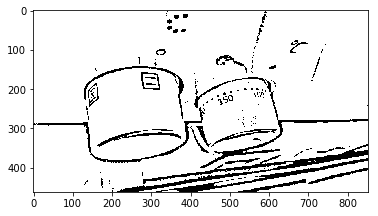

In [112]:
start = timer()

img = cv2.imread(pn, cv2.IMREAD_COLOR)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

block_size=35; offset=10
img_adapThres = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size, offset)
edges = edgeDetector(img_adapThres)

# Hough
HoughLines = hough_transformation_line(edges, 0.22)
# get mask
mask, hull = extractMask(img.shape[0], img.shape[1], HoughLines)
# cut image
img_cut = cutImage(img, hull)
gray_cut = cutImage(gray, hull)
img_adapThres_cut = cutImage(img_adapThres, hull)

img_process = img_adapThres_cut

duration = timer() - start
print(duration)

plt.imshow(img_process, cmap='gray')

## Selective Search

In [113]:
import selectivesearch
import matplotlib.patches as mpatches

In [116]:
start = timer()

# get window candidates
candidates = performSelectiveSearch(img_cut, scale=50, minRectSize=400, minSize=50, w2h=1.4)
print('number of candidates: ', len(candidates))

duration = timer() - start
print(duration)

number of candidates:  48
32.01489107981433


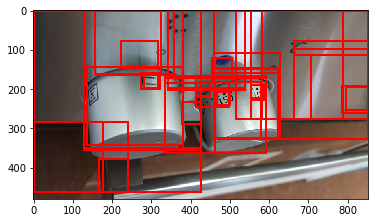

In [117]:
# draw rectangles on the original image
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax.imshow(img)
for x, y, w, h in candidates:
#     print(x, y, w, h)
    rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

plt.show()

## Distinguish 'Good' - 'Bad' candidates with an OCC

In [122]:
# parameter:

ppc = (10,10)

In [133]:
path = 'images/train_icons/o_u_heat/'
occ_clf = trainOneClassSVM('', pxPerCell=ppc, imgSize=(32,32), path=path)
occ_clf

excracted features from _ 39 _ images


OneClassSVM(cache_size=200, coef0=0.0, degree=5, gamma='auto', kernel='rbf',
      max_iter=-1, nu=0.5, random_state=None, shrinking=True, tol=0.01,
      verbose=False)

## Classify

In [33]:
# one-vs-rest classification
lin_clf = svm.LinearSVC()
lin_clf
# lin_clf.fit(X, Y) 
# dec = lin_clf.decision_function([[1]])
# dec.shape[1]


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [124]:
path = 'images/train_icons/o_u_heat/'
X_o_u_heat = extractTrainFeatures(pxPerCell=ppc, imgSize=(32,32), path=path)

path = 'images/train_icons/anti_train/'
X_anti = extractTrainFeatures(pxPerCell=ppc, imgSize=(32,32), path=path)

excracted features from _ 39 _ images
excracted features from _ 130 _ images


In [125]:
X = np.concatenate((np.array(X_o_u_heat), np.array(X_anti)))
y = np.concatenate((np.zeros(len(X_o_u_heat)), np.ones(len(X_anti))))

# multi-classification
clf = svm.SVC(decision_function_shape='ovo')
clf.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

number of candidates:  48
[[-0.16246719]]
[[-0.0748434]]
[[-0.10404119]]
[[-0.03926192]]
[[-0.07346243]]
[[-0.0683344]]
[[-0.09703758]]
[[-0.04078586]]
[[-0.09550996]]
[[-0.06457225]]
[[-0.07547322]]
[[-0.07559996]]
[[-0.04097261]]
[[-0.09703758]]
[[-0.04152764]]
[[-0.04676066]]
[[-0.14374329]]
[[-0.04221389]]
[[-0.14426941]]
[[-0.09703758]]
[[-0.07922494]]
[[-0.07809507]]
[[-0.01224192]]
occ-distance:  [[-0.01224192]]
prediction:  [ 1.]


C:\Users\JPP\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


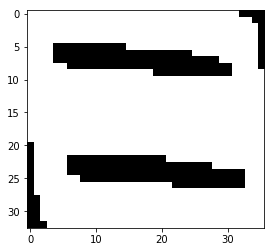

In [ ]:
print('number of candidates: ', len(candidates))

for x, y, w, h in candidates:
    window = img_process[y:y+h, x:x+w]
    hog = getResizedHOGfeature(window, ppc, size=(32,32))
    
    pred, dist = predictOneClassSVM(occ_clf, hog)
    print(dist)
    if not dist > -0.03: #pred == 1:
        continue
    
    prediction = clf.predict(hog)
    
    print('occ-distance: ', dist)
    print('prediction: ', prediction)
    
    plt.imshow(window, cmap='gray')
    plt.show()

(2,)